Notebook for Figure 5

In [118]:
%matplotlib inline

import tqdm

import xarray as xr
import numpy as np 

# importing the TDigest package
from crick import TDigest

#Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm

Loading august half-hourly precipitation data from the ICON model, file avaliable on Zenodo

In [49]:
ds = xr.open_dataset("/work/bb1153/b382291/opa_paper_data/pr_aug_2021_ICON_ngc2009_cycle3_r100.nc")
ds

<xarray.Dataset> Size: 771MB
Dimensions:  (time: 1488, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2021-08-01 ... 2021-08-31T23:30:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    pr       (time, lat, lon) float64 771MB ...

In [50]:
ds.pr

<xarray.DataArray 'pr' (time: 1488, lat: 180, lon: 360)> Size: 771MB
[96422400 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 12kB 2021-08-01 ... 2021-08-31T23:30:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Attributes:
    cell_methods:                 t: mean
    long_name:                    precipitation flux
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    units:                        kg m-2 s-1
    regridded:                    1
    history:                      \n2024-03-06 12:28:11 AQUA💧: Regrid from R0...

Converting the units from precipitation flux in kg m-2 s-1 to mm day-1 (for easier interpretability)


In [51]:
# extracting data array
pr = ds.pr

density = 998 # kg/m3 
pr =  (pr / density) * 1000  * 60 * 60 * 24

Creating a TDigest object (with a compression factor of 80) for each grid cell and adding the precipitation time series. Again not doing this is in a streaming simulator as the results from the TDigest are the same

In [52]:
digest_list = []
time_dim, lat_size, lon_size = np.shape(pr)
grid_size =  lat_size*lon_size
# flatten the lat lon grid
flat_data = np.reshape(pr.values, [len(pr.time), grid_size])

# adding the data for each grid cell to a TDigest object
for g in range(grid_size):
    digest = TDigest(compression=80)
    digest.update(flat_data[:,g])
    digest_list.append(digest)

Here we are interested in extreme rainfall so we compare the estimation of the 99th percentile from the TDigest and numpy (numpy requires the full time series in memory will TDigest the data can be added incrementally)

In [53]:
# interested in extreme rainfall so examining the 99th percentile
quantiles = 99

epsilon = 1

# saving both the absolute error and the error a a percentage of the numpy value
total_99per_error = np.zeros([1, grid_size])
total_99_error = np.zeros([1, grid_size])

large_error = []

# looping through the flattened grid
for g in tqdm.tqdm(range(grid_size)):

     #extracting the 99th percentile estimate for every grid cell
     quant_res = digest_list[g].quantile(quantiles/100)
     # calculating the numpy estimate of the 99th percentile using the linear interpolation
     np_res = np.percentile(flat_data[:,g], q = quantiles, method = 'linear')
    
     # due to errors extremely close to 0 it is possible for the percentile error to be larger than
     # 100 %. We stabilise the calcluation with the small constant epsilon. See paper for details.
     error = abs(quant_res -  np_res)
     error_per = (abs(quant_res -  np_res) /((np_res) + epsilon)) *100
     
     # if percentage error is still greater than 100, set to 0 for plotting
     if error_per > 100:
          total_99per_error[0, g] = 0
          total_99_error[0, g] = 0
          large_error.append(flat_data[:,g])
     else:
          total_99per_error[0, g] = error_per
          total_99_error[0, g] = error

print('number of error values set to 0 error is:', len(large_error))

# reshape array back to lat lon
total_99per_error = np.reshape(total_99per_error, [1, lat_size, lon_size])
total_99_error = np.reshape(total_99_error, [1, lat_size, lon_size])

  1%|▏         | 898/64800 [00:00<00:07, 8977.70it/s]

100%|██████████| 64800/64800 [00:06<00:00, 9265.32it/s]

number of error values set to 0 error is: 1


We want to examine a range of different errors from the numpy to TDigest comparision. We start by examining the location with the largest mean rainfall over the month

In [54]:
mean_pr = np.mean(pr, axis = 0)
max_index = np.argmax(mean_pr.values)
max_row, max_col = np.unravel_index(max_index, mean_pr.shape)

Want to examine the locations with the largest error. Here we find the location of the largest percentile error (based on the digests with a compression factor of 80), which corresponds to a location in Brazil

In [74]:
worst_index = np.argmax(total_99per_error)
worst_per_row, worst_per_col = np.unravel_index(worst_index, mean_pr.shape)
print('Worst percentage error:', total_99per_error[0, worst_per_row, worst_per_col], '%')

Worst percentage error: 89.75848528407265 %


In [113]:
sorted = np.sort(np.reshape(total_99_error, [1, grid_size]))
a, bad_abs_row, bad_abs_col = np.where(total_99_error == sorted[0,-45])
bad_abs_col = bad_abs_col[0]
bad_abs_row = bad_abs_row[0]

print('Bad absolute error:', total_99_error[0, bad_abs_row, bad_abs_col], 'mm day-1')

Bad absolute error: 19.735647105405235 mm day-1


Selecting four time series to examine based on the mean monthly rainfall, maximum percentage error, a bad (but not the worst) absolute error and a random location

In [114]:
# largest percentage error - Brazil
# lat: 13.5 S, lon: 60.0 W
x1 = worst_per_col
y1 = worst_per_row
brazil_tp = pr[:, y1, x1]

# mean annual rainfall - colombia
# lat: 4.5 N, lon: 78.0 W
x2 = max_col
y2 = max_row
colombia_tp = pr[:, y2, x2]

# bad absolute error - pacific ocean
# lat: 25.5 N, lon: 142 E
x3 = bad_abs_col
y3 = bad_abs_row
pacific_tp = pr[:, y3, x3]

# random - new_york
# lat: 40.5 N, lon: 75 W
x4 = 285
y4 = 130
usa_tp = pr[:, y4, x4]

Adding these 4 specific locations to TDigest objects. Here we run in 'fake' streaming but the results are the same if you don't loop through the data (shown in the commented out section)

In [115]:
compression_spacing = 2
max_comp = 140
min_comp = 20
spacing = int((max_comp - min_comp)/compression_spacing)+1
compressions = np.linspace(min_comp, max_comp, spacing)
num_compressions = len(compressions)

digest_list_b = []
digest_list_c = []
digest_list_p = []
digest_list_u = []

# creating a list of TDigest objects for each location over a range of compression factors
for i in range(num_compressions): 
    digest_list_b.append(TDigest(compression = compressions[i]))
    digest_list_c.append(TDigest(compression = compressions[i]))
    digest_list_p.append(TDigest(compression = compressions[i]))
    digest_list_u.append(TDigest(compression = compressions[i]))

    # adding the data in streaming mode
    for j in range(len(brazil_tp)):
        digest_list_b[i].update(brazil_tp[j])
        digest_list_c[i].update(colombia_tp[j])
        digest_list_p[i].update(pacific_tp[j])
        digest_list_u[i].update(usa_tp[j])
        
    # #adding the data in non-streaming mode
    # digest_list_b[i].update(brazil_tp)
    # digest_list_c[i].update(colombia_tp)
    # digest_list_p[i].update(pacific_tp)
    # digest_list_u[i].update(usa_tp)

In [116]:
digests_99p_b = np.zeros(num_compressions)
digests_99p_c = np.zeros(num_compressions)
digests_99p_p = np.zeros(num_compressions)
digests_99p_u = np.zeros(num_compressions)

centriod_num_b = np.zeros(num_compressions)
centriod_num_c = np.zeros(num_compressions)
centriod_num_p = np.zeros(num_compressions)
centriod_num_u = np.zeros(num_compressions)

quantiles = 99
# calculating the 99th percentile estimate for each compression along with corresponding number of centroids
for i in range(num_compressions):
    digests_99p_b[i] = digest_list_b[i].quantile(quantiles/100)
    digests_99p_c[i] = digest_list_c[i].quantile(quantiles/100)
    digests_99p_p[i] = digest_list_p[i].quantile(quantiles/100)
    digests_99p_u[i] = digest_list_u[i].quantile(quantiles/100)

    centriod_num_b[i] = np.size(digest_list_b[i].centroids())
    centriod_num_c[i] = np.size(digest_list_c[i].centroids())
    centriod_num_p[i] = np.size(digest_list_p[i].centroids())
    centriod_num_u[i] = np.size(digest_list_u[i].centroids())

errors = np.zeros([4, num_compressions])
errors_p = np.zeros([4, num_compressions])

errors_bars = np.zeros([8, num_compressions])
errors_bars_p = np.zeros([8, num_compressions])

percen_np = np.zeros([8])

for h in range(4):
    if h == 0:
        full_data = brazil_tp
        digests_99p = digests_99p_b
    elif h == 1:
        full_data = colombia_tp
        digests_99p = digests_99p_c
    elif h == 2:
        full_data = pacific_tp
        digests_99p = digests_99p_p
    else:  
        full_data = usa_tp
        digests_99p = digests_99p_u

    percen_np[0] = np.percentile(full_data, q = quantiles, method = 'inverted_cdf')
    percen_np[1] = np.percentile(full_data, q = quantiles, method = 'averaged_inverted_cdf')
    percen_np[2] = np.percentile(full_data, q = quantiles, method = 'closest_observation')
    percen_np[3] = np.percentile(full_data, q = quantiles, method = 'interpolated_inverted_cdf')
    percen_np[4] = np.percentile(full_data, q = quantiles, method = 'hazen')
    percen_np[5] = np.percentile(full_data, q = quantiles, method = 'weibull')
    percen_np[6] = np.percentile(full_data, q = quantiles, method = 'normal_unbiased')
    percen_np[7] = np.percentile(full_data, q = quantiles, method = 'linear')

    # calcuating the absolute and percentage errors along with error bars based on the different
    # numpy interpolation methods for calculating percentiles

    errors[h, :] = (digests_99p - percen_np[7])
    errors_p[h,:] = errors[h, :]/(percen_np[7] + epsilon) * 100

    for kl in range(len(digests_99p)): # looping through compressions 
        errors_bars[2*h+1, kl] = ((np.max(digests_99p[kl] - percen_np))  - (errors[h,kl])) # upper 
        
        errors_bars[2*h, kl] = (errors[h,kl] - np.min(digests_99p[kl] - percen_np)) # lower 
        
        errors_bars_p[(2*h)+1, kl] = ((np.max((digests_99p[kl] - percen_np)/(percen_np + epsilon)))  
                                      - errors[h,kl]/(percen_np[7]+ epsilon)) * 100 # upper 
        
        errors_bars_p[2*h, kl] = (errors[h,kl]/(percen_np[7] + epsilon) 
                                  - np.min((digests_99p[kl] - percen_np)/(percen_np+epsilon))) * 100 # lower 

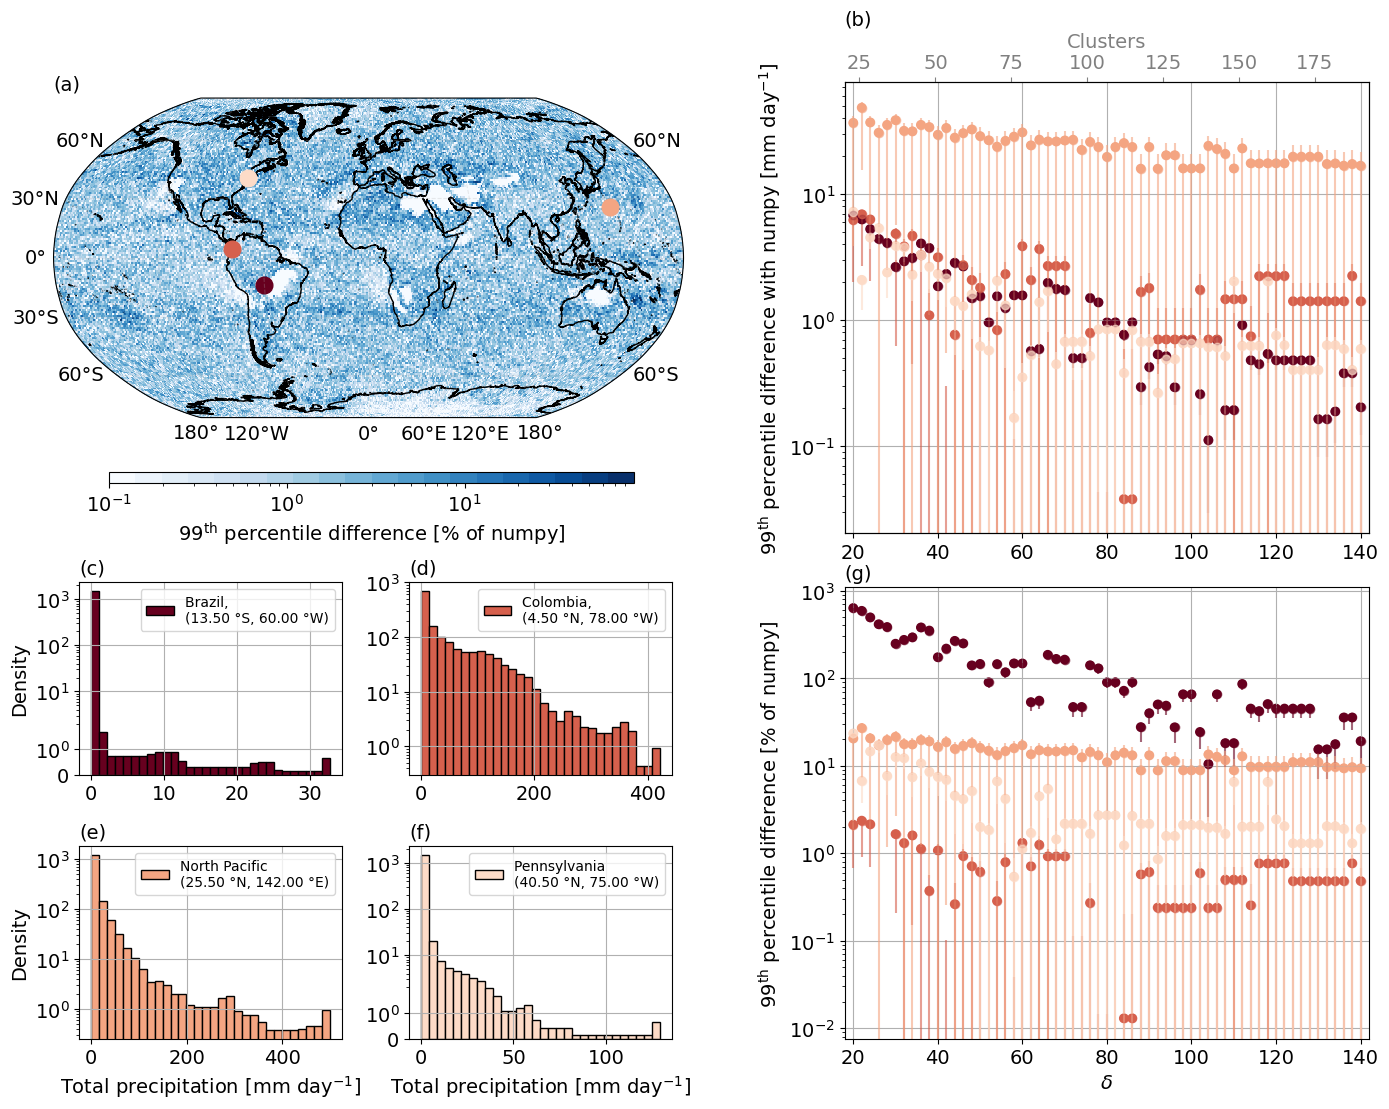

In [117]:
robinson = ccrs.Robinson()
geodetic = ccrs.Geodetic()
fig = plt.figure(constrained_layout=False, figsize=(15,11))
fig.subplots_adjust(bottom=0.1, top=0.97, left=0.01, right=0.9, wspace = 0.2, hspace = 0.25)
nrow = 2
ncol = 2

outer = gs.GridSpec(nrow,ncol,wspace=0.3,hspace=0.12, width_ratios=[0.85, 0.7])

square_size = 20
fsize = 14 # fontsize

c1 = '#67001f'
c2 = '#d6604d'
c3 = '#f4a582'
c4 = '#fddbc7'

for i in range(nrow*ncol):
    
    if i == 0:
        
        ax = fig.add_axes([0.023, 0.60, 0.42, 0.42], projection = robinson)  # [left, bottom, width, height]

        fig.subplots_adjust(bottom=0.05, top=0.99, left=0.01, right=0.9, wspace = 0.2, hspace = 0.4)
        ax.coastlines(resolution = '10m')
         #Draw meridians and parallels
        gl = ax.gridlines(draw_labels = True,linestyle='dashed',alpha=0.25)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': fsize}
        gl.ylabel_style = {'size': fsize}

        cmap = plt.get_cmap('Blues', 20)
        lon2d,lat2d = np.meshgrid(pr.lon, pr.lat)

        cs = ax.pcolormesh(lon2d, lat2d, total_99per_error[0,:,:], transform=ccrs.PlateCarree(),
                           cmap=cmap, norm = LogNorm(vmin = 0.1))

        lon1 = pr.lon[x1].values
        lat1 = pr.lat[y1].values

        lon2 = pr.lon[x2].values
        lat2 = pr.lat[y2].values

        lon3 = pr.lon[x3].values
        lat3 = pr.lat[y3].values
        
        lon4 = pr.lon[x4].values
        lat4 = pr.lat[y4].values

        #Transform the coordinates of the rectangles to the projection coordinates
        rect1 = robinson.transform_point(lon1, lat1, geodetic)
        rect2 = robinson.transform_point(lon2, lat2, geodetic)
        rect3 = robinson.transform_point(lon3, lat3, geodetic)
        rect4 = robinson.transform_point(lon4, lat4, geodetic)

        ax.plot(rect1[0], rect1[1], color=c1, marker='o', markersize=12,
                transform=robinson)
        ax.plot(rect2[0], rect2[1], color=c2, marker='o', markersize=12,
            transform=robinson)
        ax.plot(rect3[0], rect3[1], color=c3, marker='o', markersize=12,
            transform=robinson)
        ax.plot(rect4[0], rect4[1], color=c4, marker='o', markersize=12,
            transform=robinson)
        ax.set_title('(a)', fontsize = fsize, loc = 'left')

        cbar_ax = fig.add_axes([0.06, 0.605, 0.35, 0.01])
        cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')  

        cbar.set_label(r"99$^{\text{th}}$ percentile difference [$\%$ of numpy]", rotation=0, fontsize = fsize)
        cbar.ax.tick_params(labelsize=fsize)
        cbar.update_ticks()

    elif i == 2:

        ss = 0.175 # histogram size
        bins_space = 30
        digest_80_index = 30 # index for digest with compression of 80
        
        # top left (Brazil)
        # Create inset axes for the histogram        
        hist_data = digest_list_b[digest_80_index].histogram(bins_space)
        bins =  hist_data[1]
        weights = hist_data[0]

        ax_hist = fig.add_axes([0.04, 0.34, ss, ss])
        ax_hist.hist(bins[:-1], bins = bins, weights = weights, color = c1, edgecolor='black',
                    alpha = 1, label = '''Brazil, \n(13.50 °S, 60.00 °W)''')
        ax_hist.set_ylabel('Density', fontsize=fsize)
        ax_hist.tick_params('y', colors='black', labelsize=fsize)
        ax_hist.tick_params('x', colors='black', labelsize=fsize)
        ax_hist.grid(True)
        ax_hist.set_title('(c)', fontsize = fsize, loc = 'left')
        ax_hist.set_yscale('symlog',base = 10, subs = [2, 3, 4, 5, 6, 7, 8, 9])
        ax_hist.legend(ncol=2)
        
        # top right (Colombia)
        hist_data = digest_list_c[digest_80_index].histogram(bins_space)
        bins =  hist_data[1]
        weights = hist_data[0]

        ax_hist = fig.add_axes([0.26, 0.34, ss, ss])
        ax_hist.hist(bins[:-1], bins = bins, weights = weights, color = c2, edgecolor='black', 
                     alpha = 1, log = True, label = '''Colombia, \n(4.50 °N, 78.00 °W)''')
        ax_hist.tick_params('y', colors='black', labelsize=fsize)
        ax_hist.tick_params('x', colors='black', labelsize=fsize)
        ax_hist.grid(True)
        ax_hist.legend()
        ax_hist.set_title('(d)', fontsize = fsize, loc = 'left')

        # bottom left (North Pacific)
        hist_data = digest_list_p[digest_80_index].histogram(bins_space)
        bins =  hist_data[1]
        weights = hist_data[0]
        
        ax_hist = fig.add_axes([0.04, 0.10, ss, ss])
        ax_hist.hist(bins[:-1], bins = bins, weights = weights, color = c3, edgecolor='black', 
                     alpha = 1, log = True, label = '''North Pacific \n(25.50 °N, 142.00 °E)''')
        ax_hist.set_xlabel(r'Total precipitation [mm day$^{-1}$]', fontsize=fsize)
        ax_hist.set_ylabel('Density', fontsize=fsize)
        ax_hist.tick_params('y', colors='black', labelsize=fsize)
        ax_hist.tick_params('x', colors='black', labelsize=fsize)
        ax_hist.grid(True)
        ax_hist.legend()
        ax_hist.set_title('(e)', fontsize = fsize, loc = 'left')

        # bottom right (Pennsylvania - new york)
        hist_data = digest_list_u[digest_80_index].histogram(bins_space)
        bins =  hist_data[1]
        weights = hist_data[0]
    
        ax_hist = fig.add_axes([0.26, 0.10, ss, ss])
        ax_hist.hist(bins[:-1], bins = bins, weights = weights, color = c4, edgecolor='black', 
                     alpha = 1, label = '''Pennsylvania \n(40.50 °N, 75.00 °W)''')
        ax_hist.set_xlabel(r'Total precipitation [mm day$^{-1}$]', fontsize=fsize)
        ax_hist.set_yscale('log', subs = [2, 3, 4, 5, 6, 7, 8, 9])
        ax_hist.tick_params('y', colors='black', labelsize=fsize)
        ax_hist.tick_params('x', colors='black', labelsize=fsize)
        ax_hist.grid(True)
        ax_hist.legend()
        ax_hist.set_title('(f)', fontsize = fsize, loc = 'left')
        ax_hist.set_yscale('symlog', subs = [ 2, 3, 4, 5, 6, 7, 8, 9])

    elif i == 1:
        # making the absolute error plot
        alpha = 0.6
        fig.subplots_adjust(bottom=0.1, top=0.97, left=0.01, right=0.9, wspace = 0.2, hspace = 0.2)
    
        ax = plt.subplot(outer[i])
        ax.errorbar(compressions, errors[0, :], yerr = errors_bars[0:2, :], marker = 'o', color=c1,
                    alpha = 0.6, linestyle='')
        ax.errorbar(compressions, errors[1, :], yerr = errors_bars[2:4, :], marker = 'o', color=c2,
                    alpha = 0.6, linestyle='')
        ax.errorbar(compressions, errors[2, :], yerr = errors_bars[4:6, :], marker = 'o', color=c3,
                    alpha = 0.6, linestyle='')
        ax.errorbar(compressions, errors[3, :], yerr = errors_bars[6:8, :], marker = 'o', color=c4,
                    alpha = 0.6, linestyle='')
        ax.set_ylabel(r'99$^{\text{th}}$ percentile difference with numpy [mm day$^{-1}$]', fontsize=fsize)
        ax.set_xlim([np.min(compressions)-2, np.max(compressions)+2])
        ax.tick_params('y', colors='black', labelsize=fsize)
        ax.tick_params('x', colors='black', labelsize=fsize)
        ax.grid(True)
        ax.set_yscale('log')
        ax.set_title('(b)', fontsize = fsize, loc = 'left')
        
        ax.scatter(compressions, errors[0, :], marker = 'o', color=c1, linestyle='')
        ax.scatter(compressions, errors[1, :], marker = 'o', color=c2, linestyle='')
        ax.scatter(compressions, errors[2, :], marker = 'o', color=c3, linestyle='')
        ax.scatter(compressions, errors[3, :], marker = 'o', color=c4, linestyle='')

        #Create a second x-axis sharing the same x-axis
        ax2 = ax.twiny()
        ax2.scatter(centriod_num_u, errors[0, :], color='gray', marker = '')
        ax2.set_xlabel('Clusters', color='gray', fontsize = fsize)
        ax2.tick_params('x', colors='gray', labelsize = fsize)

    elif i == 3:
        # making the percentage error graph
        ax = plt.subplot(outer[i])
                
        ax.errorbar(compressions, errors_p[0, :], yerr = errors_bars_p[0:2, :], 
                    marker = 'o', color=c1,linestyle='', alpha=alpha)
        ax.errorbar(compressions, errors_p[1, :], yerr = errors_bars_p[2:4, :], 
                    marker = 'o', color=c2,linestyle='', alpha=alpha)
        ax.errorbar(compressions, errors_p[2, :], yerr = errors_bars_p[4:6, :], 
                    marker = 'o', color=c3,linestyle='', alpha=alpha)
        ax.errorbar(compressions, errors_p[3, :], yerr = errors_bars_p[6:8, :], 
                    marker = 'o', color=c4,linestyle='', alpha=alpha)

        ax.scatter(compressions, errors_p[0, :], marker = 'o', color=c1,linestyle='')
        ax.scatter(compressions, errors_p[1, :], marker = 'o', color=c2,linestyle='')
        ax.scatter(compressions, errors_p[2, :], marker = 'o', color=c3,linestyle='')
        ax.scatter(compressions, errors_p[3, :], marker = 'o', color=c4,linestyle='')
        ax.set_yscale('log')
        ax.set_xlim([np.min(compressions)-2, np.max(compressions)+2])
        ax.set_xlabel(r'$\delta$', fontsize=fsize)
        ax.set_ylabel(r'99$^{\text{th}}$ percentile difference [% of numpy]', fontsize=fsize)

        ax.tick_params('y', colors='black', labelsize=fsize)
        ax.tick_params('x', colors='black', labelsize=fsize)
        ax.grid(True)
        ax.set_title('(g)', fontsize = fsize, loc = 'left')

plt.show()